<a href="https://colab.research.google.com/github/GiovanniTagliaferri/Thesis-clustering-tweets/blob/main/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLUSTERING

Dato un insieme di elementi, può essere utile raggrupparli per categorie per comprendere un certo argomento. Se il raggruppamento prevede la suddivisione degli elementi in varie classi (o etichette), allora viene detto **classificazione** e si basa su un modello di machine learning supervisionato.

Il **clustering**, invece,  consiste nel raggruppamento senza etichetta di un certo insieme di elementi e si basa sul machine learning non supervisionato.
Gli elementi dell'insieme vengono raggruppati per *elementi simili*, quindi bisogna stabilire prima una **misura della somiglianza**.

Esistono diversi algoritmi di clustering, ognuno più adatto per essere applicato su un set di dati diverso. Non tutti gli algoritmi di clustering scalano in modo efficiente: alcuni misurano la somiglianza tra tutte le coppie di esempi e quindi comporta un costo di $O(n^2)$. Se il set ha milioni di esempi, si capisce bene che un algoritmo del genere è poco efficiente. Un algoritmo che invece ha una complessità di $O(n)$ è il cosiddetto **algoritmo k-means**, cioè scala in maniera lineare con $n$.

A seconda della distribuzione dei dati è più conveniente utilizzare un determinato approccio. Sfruttando l'agoritmo k-means, i più comuni sono i seguenti.

## CLUSTERING CENTROID
Gli algoritmi basati sui **centroidi** organizzano i dati in cluster non gerarchici. Essi sono efficienti ma sensibili alle condizioni iniziali e alle anomalie.

## CLUSTERING BASATO SULLA DENSITÀ
Gli algoritmi di questo tipo collegano le aree ad alta densità di esempio in cluster. Ciò consente distribuzioni di forma arbitraria a patto che aree dense possono essere connesse. Tuttavia sorgono difficoltà con dati di densità diverse, e inoltre alle anomalie non vengono assegnati valori.

## CLUSTERING BASATO SULLA DISTRIBUZIONE
In questo approccio si prevede che i dati siano composti da più distribuzioni (per esempio Gaussiane). Più aumenta la distanza dal centro della distribuzione, più la probabilità che un punto appartenga alla distribuzione diminuisce.

## CLUSTERING GERARCHICO
Crea una struttura ad albero di cluster.

# IMPORTO I TWEET
Import i tweets riguardanti la guerra in Ucraina da quando e' iniziata (24 febbraio 2022) fino al 23 novembre 2022 e li suddivido per mesi (dal giorno 24 ora 00:00 di un mese al 23 ora 23:59 del mese successivo). Per ogni tweet vengono salvati: il testo, l'id, l'user che lo ha scritto, il luogo, la data e l'ora, l'informazione sul fatto se sia un tweet originale o un retweet, il numero di eventuali retweet, una eventuale foto presente nel tweet e infine l'url.
Per ogni mese sono previsti due file .json:
*   uno *raw* in cui vengono salvati i tweet con il testo così come è
*   uno *clean* dove il testo dei tweet ha subito un'operazione di "pulizia" (si veda più avanti in cosa consiste).

In [ ]:
!pip install tweepy
!pip install pandas
!pip install better_profanity
!pip install textblob
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 1.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 981 kB 15.0 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=0b759ba5ae7bc43b0e7884b4e0501e1f134ad0e3fa2396c2eddb3d0c08318cce
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


In [ ]:
import tweepy   # API per importare dati da Twitter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from better_profanity import profanity
import langdetect
import re

# CREDENZIALI
BEARER_TOKEN = "AAAAAAAAAAAAAAAAAAAAAFGeiwEAAAAARepHGf9jvasGh6jtCZ7cSm32Fv0%3DRXiplgGUHKgQ4esdQcJQfA2qVhb4QBT0Xzdc4jbudaN4fYhuLO"
ACCESS_TOKEN = "1456205100-pHRLPHyPvE1VlC6Cty9qxyPWf9GFiJRAuEOofx5"
ACCESS_TOKEN_SECRET = "WAG2uGIYa6bGSO0aTN0mc88tUDIjSVkvXnJTHF0sfQ97B"
API_KEY = "BkcawOx9kHTLcprjB1vk6Lazd"
API_KEY_SECRET = "27FpVac8aHRpKZAtMeEDvt0l7dqFrxoWd6QVtUPavTYLPgDDJE"
CLIENT_ID= "LUhHQ0RERmpGQ2c4MDhKRXJGRms6MTpjaQ"
CLIENT_SECRET = "hOIUfkyy_mFTJO4ii8X9D-hOU_eiNORZHrziPogSPDgxaQT9Sn"

# AUTENTICAZIONE
auth = tweepy.OAuthHandler(API_KEY, API_KEY_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

api = tweepy.API(auth)  # permette l'accesso all'account di twitter

In [ ]:
# funzione che verifica se il testo di un tweet era gia' stato scritto da un altro utente
def uguale(testo, lista):
    for tw in lista:
        if testo == tw[1]:
            return True
    return False

# funzione che dato un tweet, lo "pulisce"
def clean_tweets(tweet):
    if type(tweet) == float:
        return ""
    r = tweet.lower()
    r = profanity.censor(r)               # rimuovo le "profanity" (volgarita')
    r = re.sub("'", "", r)                # rimuovo l'apostrofo
    r = re.sub("@[A-Za-z0-9_]+", "", r)   # rimuovo le menzioni
    r = re.sub("#[A-Za-z0-9_]+", "", r)   # rimuovo gli hashtag
    r = re.sub('[()!?]', "", r)         # rimuovo caratteri speciali
    r = re.sub(r'http\S+', '', r)         # rimuovo i link
    r = re.sub('\[.*?\]',' ', r)
    r = re.sub("[^a-z0-9]"," ", r)
    r = r.split()
    stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from", "rt"]
    r = [w for w in r if not w in stopwords]  # prendo solo le parole che NON stanno in stopwords
    r = " ".join(word for word in r)
    return r

In [ ]:
# data una query, importo un certo numero di tweets e creo un dataset
# query = '"ukraine war" OR "ukraine russia" OR "ukraine zelensky" OR "ukraina putin" -filter:retweets since:2022-11-11'
limit = 200

# inizio guerra 24 02 2022
# date_start = "202202240000"
# date_end = "202203232359"

# tweets = tweepy.Cursor(api.search_full_archive, environment_name="development", query=query, fromDate=date_start, toDate=date_end, tweet_mode='extended').items(limit)
# tweets=tweepy.Cursor(api.search, q=query, tweet_mode='extended', result_type='recent', lang='en').items(limit)
tweets=tweepy.Cursor(api.home_timeline, tweet_mode='extended', wait_on_rate_limit=True).items(limit)

# creo la lista di tweets che rispettano la query
lista_tweets = []

for tweet in tweets:
    # controllo se ha una foto: se il blocco try fallisce e' perche' il tweet in questione non ha un elemento "media"
    try:
      media = tweet.entities["media"][0]["media_url"]   # prendo l'url dell'eventuale foto
    except:
      media = ""
    url = f"https://twitter.com/{tweet.user.screen_name}/status/{tweet.id}"
    lista_tweets.append([tweet.id, tweet.full_text, tweet.user.screen_name, tweet.user.location, tweet.created_at, tweet.retweet_count, media, url])

# dataframe con i tweet "raw", cioe' come sono scritti dagli utenti
df_raw = pd.DataFrame(data=lista_tweets, columns=['id', 'text', 'user', 'location', 'created_at', 'retweet_count', 'image', 'url'])
df_raw

,id,text,user,location,created_at,retweet_count,image,url
0,1597893231114690561,Like most major tourism hotspots around the wo...,CNN,,2022-11-30 10:00:08,6,,https://twitter.com/CNN/status/159789323111469...
1,1597893209946193920,"Cina, morto a 96 anni l'ex presidente Jiang Ze...",repubblica,"Rome, Italy",2022-11-30 10:00:03,0,,https://twitter.com/repubblica/status/15978932...
2,1597892329779912707,"Gambizzato dopo lite su viabilità, due arresti...",SkyTG24,,2022-11-30 09:56:33,2,,https://twitter.com/SkyTG24/status/15978923297...
3,1597891728694018048,"Incidente stradale nel Padovano, 26enne muore ...",fattoquotidiano,Roma e Milano,2022-11-30 09:54:10,0,,https://twitter.com/fattoquotidiano/status/159...
4,1597891720196558849,"""Quell'uomo annaspava nel canale gelato"", si t...",repubblica,"Rome, Italy",2022-11-30 09:54:08,0,,https://twitter.com/repubblica/status/15978917...
...,...,...,...,...,...,...,...,...
195,1597802613529083904,Look at how our #XiaomiFans showcased their sm...,Xiaomi,,2022-11-30 04:00:03,21,http://pbs.twimg.com/media/FiyJALnWAAAzlgX.jpg,https://twitter.com/Xiaomi/status/159780261352...
196,1597802494331322374,"Armi a Kiev, pasticcio del governo: farà un de...",repubblica,"Rome, Italy",2022-11-30 03:59:35,2,,https://twitter.com/repubblica/status/15978024...
197,1597802198750351362,RT @movie_slamdunk: ◤\n 試合開始まであと3日\n ...,inouetake,"日本国東京 Tokyo,JAPAN",2022-11-30 03:58:24,6254,http://pbs.twimg.com/ext_tw_video_thumb/159720...,https://twitter.com/inouetake/status/159780219...
198,1597802182577098752,How could you do this to your OWN TEAMMATE? 🤮 ...,overtime,,2022-11-30 03:58:20,146,http://pbs.twimg.com/ext_tw_video_thumb/159780...,https://twitter.com/overtime/status/1597802182...


Creo un dataframe con i tweet *clean*, cioe' dove il contenuto dei tweet e' stato conventito tutto in minuscolo, pulito da caratteri speciali, segni di punteggiatura, parole inutili ai fini dell'analisi (le cosiddette *stop-words*), volgarita', tags e link.

In [ ]:
cleaned_tweets = []
# METTERE LIMITE DI TWEET
for i in range(0,len(df_raw)):
    id = df_raw["id"][i]
    user = df_raw["user"][i]
    location = df_raw["location"][i]
    created_at = df_raw["created_at"][i]
    retweet_count = df_raw["retweet_count"][i]
    image = df_raw["image"][i]
    url = df_raw["url"][i]

    testo = clean_tweets(df_raw["text"][i])   # pulisco il testo di un tweet

    # se trovo un tweet gia' salvato con lo stesso testo clean vado alla prossima iterazione
    if len(cleaned_tweets) > 0 and uguale(testo, cleaned_tweets):
        continue

    cleaned_tweets.append([id, testo, user, location, created_at, retweet_count, image, url])

df_cleaned = pd.DataFrame(data=cleaned_tweets, columns=['id', 'text', 'user', 'location', 'created_at', 'retweet_count', 'image', 'url'])
df_cleaned

,id,text,user,location,created_at,retweet_count,image,url
0,1597893231114690561,like most major tourism hotspots around world ...,CNN,,2022-11-30 10:00:08,6,,https://twitter.com/CNN/status/159789323111469...
1,1597893209946193920,cina morto 96 anni lex presidente jiang zemin,repubblica,"Rome, Italy",2022-11-30 10:00:03,0,,https://twitter.com/repubblica/status/15978932...
2,1597892329779912707,gambizzato dopo lite su viabilit due arresti n...,SkyTG24,,2022-11-30 09:56:33,2,,https://twitter.com/SkyTG24/status/15978923297...
3,1597891728694018048,incidente stradale nel padovano 26enne muore d...,fattoquotidiano,Roma e Milano,2022-11-30 09:54:10,0,,https://twitter.com/fattoquotidiano/status/159...
4,1597891720196558849,quelluomo annaspava nel canale gelato si tuffa...,repubblica,"Rome, Italy",2022-11-30 09:54:08,0,,https://twitter.com/repubblica/status/15978917...
...,...,...,...,...,...,...,...,...
189,1597802613529083904,look at how our showcased their smart lives wi...,Xiaomi,,2022-11-30 04:00:03,21,http://pbs.twimg.com/media/FiyJALnWAAAzlgX.jpg,https://twitter.com/Xiaomi/status/159780261352...
190,1597802494331322374,armi kiev pasticcio del governo far un decreto...,repubblica,"Rome, Italy",2022-11-30 03:59:35,2,,https://twitter.com/repubblica/status/15978024...
191,1597802198750351362,3 first slam dunk,inouetake,"日本国東京 Tokyo,JAPAN",2022-11-30 03:58:24,6254,http://pbs.twimg.com/ext_tw_video_thumb/159720...,https://twitter.com/inouetake/status/159780219...
192,1597802182577098752,how could you do this your own teammate via,overtime,,2022-11-30 03:58:20,146,http://pbs.twimg.com/ext_tw_video_thumb/159780...,https://twitter.com/overtime/status/1597802182...


# ANALISI DEI TWEETS
In questa sezione si applicano dei modelli di Machine Learning per studiare il contenuto dei tweets.
Per fare ciò utilizzo un **sentence-transformers**, un framework di Python che
permette di rappresentare le parole di un testo in un nuovo dominio in cui la loro rappresentazione si assomiglia se hanno un significato simile tra loro.

Questo framework offre una vasta collezione di modelli pre-addestrati utilizati per di diversi task. Uno è il **all-MiniLM-L6-v2** che mappa frasi e paragrafi come vettori in uno spazio di dimensione 384 che può essere utilizzato per vari compiti come il clustering o la ricerca di una semantica.


Una volta aver codificato ogni frase e quindi aver ottenuto un vettore per ognuna, è possibilie misurare il grado di somiglianza con la tecnina del **cosine similarity**: dati due vettori, si misura il coseno dell'angolo tra essi dato dal prodotto scalare tra i due vettori diviso le loro lunghezze. Il coseno varia in [-1, 1], quindi, per esempio, vale 1 se i due vettori sono proporzionali, 0 se sono perpendicolari.

Utilizzo un *pickle* per salvare e scaricare su disco embeddings pre-compilati, utile per codificare un grande numero di frasi.

Per effettuare il clustering applico l'algoritmo **Density-Based Spatial Clustering of Applications** (**DBSC**) che tiene conto delle differenze di densità tra le osservazioni nello spazio delle feature. L'algoritmo è in grado di clusterizzare campioni vicini tra loro e di individuare le anomalie (*outliers*), cioè punti che non rientrano in nessuno degli insiemi individuati.

Il DBSCAN si basa su due iperparametri:
*   ε : che corrisponde alla distanza all'interno della quale ricercare punti vicini
*   min_samples : che corrisponde al numero minimo di punti affinchè si formi un cluster.

In [ ]:
!pip install -U sentence-transformers
!pip install -U -q PyDrive
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.8 MB/s 
     |████████████████████████████████| 5.5 MB 57.1 MB/s 
     |████████████████████████████████| 1.3 MB 52.4 MB/s 
     |████████████████████████████████| 182 kB 69.0 MB/s 
     |████████████████████████████████| 7.6 MB 55.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=72c597a7448ac7ef3bdad0bae2f506756fd4a41c73b3241f04d533df01dadb37
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import pickle
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import DBSCAN
import pandas as pd
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import json
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn import metrics
import json
import seaborn as sns
sns.set()
%matplotlib inline

# scelgo il modello per codificare i testi dei tweets
model = SentenceTransformer('all-mpnet-base-v2')

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# mi autentifico a google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# ottengo il file da Google drive e lo carico in colab
link = "https://drive.google.com/file/d/1kktwDR1Ihx3OBNVy9J7pKO2UfSbFWbh6/view?usp=share_link"
file_name = 'home.json'
id='1kktwDR1Ihx3OBNVy9J7pKO2UfSbFWbh6'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(file_name)

In [ ]:
with open('home.json') as f:
   df_tweets = json.load(f)   # ottengo la lista di tweets in formato json

# trasformo la lista in dizionario
tweets = {}

for tw in range(len(df_tweets)):
    tweets[tw] = []
    tweets[tw].append({'id': df_tweets[tw]['id'],
                       'text': df_tweets[tw]['text'],
                       'user': df_tweets[tw]['user'],
                       'location': df_tweets[tw]['location'],
                       'created_at': df_tweets[tw]['created_at'],
                       'retweet_count': df_tweets[tw]['retweet_count'],
                       'image': df_tweets[tw]['image'],
                       'url': df_tweets[tw]['url']
                       })

In [ ]:
tweets_text = []  # insieme dei testi dei tweet
for i in range(len(tweets)):
    tweets_text.append(tweets[i][0]['text'])

# codifico le frasi
embeddings = model.encode(tweets_text)

# salvo frasi e embeddinds su disco
with open('embeddings.pkl', "wb") as fOut:
    pickle.dump({'sentences': tweets_text, 'embeddings': embeddings}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

embeddings.shape

(194, 768)

Per evitare problemi legati alla diversa scala delle variabili nella pratica si usa **standardizzare** il dataset. La standardizzazione di una singola variabile consiste nell'applicazione delle seguente formula:

$x⃗ std=(x⃗ −μ)/σ$

Applicando a ogni colonna questa procedura, ottengo le variabili *standardizzate* (cioè con media nulla e deviazione standard pari a 1). In Python il procedimento è implementato tramite il metodo *StandardScaler()*.

In [ ]:
# dal pickle estraggo gli embeddings e li organizzo in un dataframe
emb = pd.read_pickle('embeddings.pkl')
dataframe = pd.DataFrame(emb['embeddings'])
X = pd.DataFrame(dataframe).to_numpy()  # converto il dataframe in un array
scaler = StandardScaler()
X = scaler.fit_transform(X)   # scalo le variabili
scaled_dataframe = pd.DataFrame(X, columns = dataframe.columns)   # dall'array scalato ottengo il dataframe delle variabili scalate

In [ ]:
scaled_dataframe.describe()   # osservo che le medie sono circa zero e le varianze circa 1

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
count,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,194.000000,...,1.940000e+02,1.940000e+02,194.000000,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02,1.940000e+02
mean,9.831694e-09,1.474754e-08,-9.831694e-09,-4.915847e-09,-1.966339e-08,9.831694e-09,9.831694e-09,-1.474754e-08,4.915847e-09,0.000000,...,1.228962e-08,-1.966339e-08,0.000000,-7.373770e-09,-4.915847e-09,-9.831694e-09,9.831694e-09,-1.966339e-08,1.966339e-08,9.831694e-09
std,1.002587e+00,1.002587e+00,1.002587e+00,1.002587e+00,1.002587e+00,1.002587e+00,1.002587e+00,1.002587e+00,1.002587e+00,1.002587,...,1.002587e+00,1.002587e+00,1.002587,1.002587e+00,1.002587e+00,1.002587e+00,1.002587e+00,1.002587e+00,1.002587e+00,1.002587e+00
min,-2.590664e+00,-2.677021e+00,-3.096323e+00,-3.386626e+00,-3.064250e+00,-2.485069e+00,-3.154678e+00,-2.934970e+00,-2.671118e+00,-3.301726,...,-1.930879e+00,-2.170608e+00,-2.833174,-2.368186e+00,-2.769717e+00,-2.805717e+00,-2.313116e+00,-3.028752e+00,-2.592924e+00,-2.704426e+00
25%,-5.586863e-01,-6.982455e-01,-5.876236e-01,-6.367867e-01,-6.448592e-01,-7.243764e-01,-4.869753e-01,-6.561249e-01,-5.986456e-01,-0.686708,...,-7.570941e-01,-7.492166e-01,-0.514521,-5.986511e-01,-6.790136e-01,-7.355741e-01,-6.833910e-01,-5.328958e-01,-5.846041e-01,-6.595759e-01
50%,2.636934e-02,9.075476e-02,1.417454e-03,5.570322e-02,2.483673e-02,-1.376922e-02,1.538180e-01,1.278240e-01,-4.868064e-02,0.018362,...,-5.442487e-02,-5.483697e-02,0.138422,-1.790429e-02,3.981332e-02,-6.226158e-02,-1.328312e-01,8.770252e-02,6.018665e-02,-7.063541e-03
75%,5.942743e-01,7.253575e-01,6.664106e-01,6.863502e-01,7.884332e-01,7.463008e-01,7.536319e-01,7.227433e-01,7.920599e-01,0.566398,...,5.333040e-01,6.476121e-01,0.668640,5.788049e-01,7.014551e-01,7.256283e-01,6.040192e-01,7.611543e-01,6.352593e-01,7.041397e-01
max,2.932493e+00,2.563709e+00,2.826879e+00,2.328905e+00,1.857431e+00,2.307486e+00,2.027130e+00,2.512927e+00,2.302546e+00,3.035877,...,4.589690e+00,2.545318e+00,2.532017,3.691726e+00,3.331198e+00,2.260865e+00,3.849456e+00,1.987749e+00,3.185410e+00,3.426259e+00


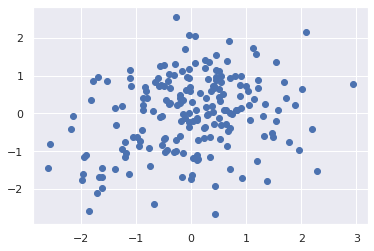

In [ ]:
# X, labels_true = make_blobs(n_samples=292, cluster_std=1, random_state=0, n_features=768)
plt.scatter(X[:,0], X[:, 1])

Il valore di epsilon non viene prodotto in modo ottimale automaticamente dal DBSCAN, pertanto per determinarlo si utilizza un particolare algoritmo detto **elbow tecnique** che calcola epsilon per ogni livello di densità nel data set. In particolare, l'algoritmo calcola la distanza tra ogni punto e i suoi k (di default vale 5) vicini (*neighbors*) e ne esegue la media. In seguito tutte le k-distanze medie così calcolate vengono graficate in ordine crescente. Da qui, il valore ottimale di eps si trova nel punto di massima curvatura del grafico, cioè nel cosiddetto *gomito*, da qui il nome dell'algoritmo.

Il calcolo della distanza viene implementato dal metodo *NearestNeighbors*.

In [ ]:
# funzione che mostra graficamente la distanza media tra gli elementi dell'insieme considerato
def graficoEps(embeddings):
    neigh = NearestNeighbors()
    nbrs = neigh.fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

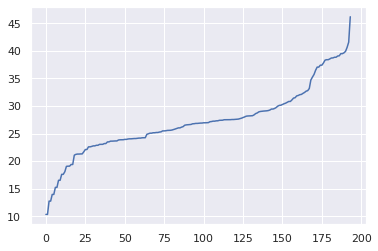

In [ ]:
graficoEps(X)

In [ ]:
for i in range(30, 40, 1):
    print(f"Per eps={i}")
    db = DBSCAN(eps=i).fit(X)
    y_pred=db.fit_predict(X)
    labels = db.labels_
    print(np.unique(labels))
    print(silhouette_score(X,labels))
    print()

Per eps=30
[-1  0  1]
0.12364365

Per eps=31
[-1  0  1]
0.13956794

Per eps=32
[-1  0  1]
0.16666327

Per eps=33
[-1  0  1]
0.17634355

Per eps=34
[-1  0]
0.1408581

Per eps=35
[-1  0]
0.14473364

Per eps=36
[-1  0]
0.14416786

Per eps=37
[-1  0]
0.1472632

Per eps=38
[-1  0]
0.14674936

Per eps=39
[-1  0]
0.1492451



In [ ]:
db = DBSCAN(eps=33).fit(X)
y_pred=db.fit_predict(X)
labels = db.labels_
print(np.unique(labels))
silhouette_score(X,labels)

[-1  0  1]


0.17634355

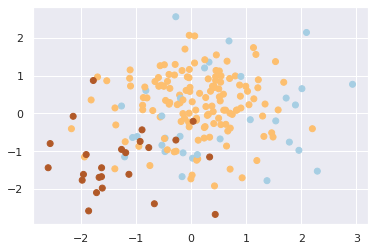

In [ ]:
plt.scatter(X[:,0], X[:, 1], c=y_pred, cmap="Paired")

In un dizionario le cui chiavi sono le labels e ognuna ha come valore la lista degli id dei tweet che appartengono a quel cluster.

In [ ]:
groups = {}
for i, cluster in enumerate(labels):
    id = tweets[i][0]['id']
    if cluster not in groups.keys():
        groups[cluster] =[]
        groups[cluster].append(id)
    else:
        groups[cluster].append(id)

In [ ]:
for k in groups.keys():   # scorro tra le labels
    print(f"TWEET APPARTENENTI AL CLUSTER {k}: \n")
    for id in groups[k]:    # scorro tra i tweets che appartengono a un cluster
        for tw in tweets:
            if tweets[tw][0]['id'] == id:
                print(tweets[tw][0]['text'])
    print("\n\n")

TWEET APPARTENENTI AL CLUSTER 0: 

si pu rivoluzionare un classico rimanendovi fedele profondit certamente purch compierlo sia la mente di un grande artista
frana ischia sono almeno 8 i morti accertati
incidenti stradali nola tre giovani si schiantano un morto
previsioni meteo arrivo una serie di cicloni il primo quello che sta colpendo ischia
vittorio cecchi gori ho comprato una casa di trump e oggi mi ritrovo spolpato da gente senza scrupoli
fino al 27 novembre al teatro carcano va scena le nostre anime di notte
clima frana ischia sima 130 eventi estremi solo nel 2022 1 318 dal 2010
sondaggi politici meloni fiducia governo
esplosione bombole gas nel reggino un morto e due feriti
l incontro era nell aria dopo le ripetute critiche delle madri russe alla guerra cui vengono mandati morire i propri figli
vinse due volte loscar per hit come fame e flashdance what feeling la cantante e attrice statunitense irene cara pseudonimo di irene cara escalera si spenta nella sua casa florida ma non 

## CLUSTERING IMMAGINI

In [ ]:
from transformers import VisionEncoderDecoderModel, ViTFeatureExtractor, AutoTokenizer
from sentence_transformers import SentenceTransformer, util
import torch
import io
from PIL import Image
import requests
import urllib.request
from io import BytesIO

# definisco il modello utilizzato per le immagini e, se trovo la GPU disponibile, consento l'esecuzione su essa
model1 = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
if torch.cuda.is_available():
    model1.cuda()

feature_extractor = ViTFeatureExtractor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 16
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

Downloading:   0%|          | 0.00/982M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/241 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [ ]:
# nel dizionario 'urls' salvo le coppie id tweet => url dell'immagine (ovviamente solo per i tweet che hanno un'immagine allegata)
urls = {}
for tw in tweets:
    if tweets[tw][0]['image'].startswith("http"):
        urls[tweets[tw][0]['id']] = []
        urls[tweets[tw][0]['id']].append(tweets[tw][0]['image'])

In [ ]:
urls

{'1596464296720216066': ['http://pbs.twimg.com/media/FifHmwjXgAALzIG.jpg'],
 '1596464144743628803': ['http://pbs.twimg.com/media/FifHf14X0AA59OF.jpg'],
 '1596462433819729920': ['http://pbs.twimg.com/media/FifGHuRWAAIzN4F.jpg'],
 '1596460608957730821': ['http://pbs.twimg.com/media/FifDYODWIAA1Swd.jpg'],
 '1596455655715446784': ['http://pbs.twimg.com/media/Fie_9XPWYAI3FKu.jpg'],
 '1596453227318460417': ['http://pbs.twimg.com/amplify_video_thumb/1596338364646445057/img/Ini7Ku3KZhS2G2o8.jpg'],
 '1596436921638653952': ['http://pbs.twimg.com/amplify_video_thumb/1596339497704169472/img/tJZ6uZ2FLApfo4n7.jpg'],
 '1596436543576887296': ['http://pbs.twimg.com/amplify_video_thumb/1596312574790107137/img/bKIO5CRu_VC9Z2Zn.jpg'],
 '1596428954403061760': ['http://pbs.twimg.com/media/FienqyeXgAsyc9D.jpg'],
 '1596427779587080195': ['http://pbs.twimg.com/media/FiemhdwWQAcV4bT.jpg'],
 '1596413637820022785': ['http://pbs.twimg.com/media/FiXFPoLUUAA1VuH.jpg'],
 '1596411950677651456': ['http://pbs.twimg.com/

In [ ]:
# funzione che restituisce una caption dell'immagine di cui viene passato l'url

def predict_step(image_urls):  # image_urls contiene gli url delle
  images = []   # lista immagini inizialmente vuota
  for id in image_urls:  # scorro gli url delle immagini
    response = requests.get(image_urls[id][0])
    i_image = Image.open(BytesIO(response.content))
    if i_image.mode != "RGB":
      i_image = i_image.convert(mode="RGB")

    images.append(i_image)

  pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
  pixel_values = pixel_values.to(device)

  output_ids = model1.generate(pixel_values, **gen_kwargs)

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]
  captions = []

  for id, p in zip(image_urls, preds):
      captions.append({'id': id, 'pred': p})    # lista di dizionari contenenti gli id dei tweet e le captions delle immagini
  return captions

captions = predict_step(urls)

In [ ]:
captions

[{'id': '1596464296720216066',
  'pred': 'a painting of a man in a suit and tie'},
 {'id': '1596464144743628803', 'pred': 'a painting of a man on a surfboard'},
 {'id': '1596462433819729920',
  'pred': 'a woman in a red dress holding a red and white fire hydrant'},
 {'id': '1596460608957730821',
  'pred': 'a collage of photos showing a woman holding a cell phone'},
 {'id': '1596455655715446784',
  'pred': 'a night scene with lights on a night stand'},
 {'id': '1596453227318460417',
  'pred': 'a basketball game is being played on a court'},
 {'id': '1596436921638653952', 'pred': 'a man wearing a suit and tie'},
 {'id': '1596436543576887296',
  'pred': 'a black and white photo of a clock on a wall'},
 {'id': '1596428954403061760',
  'pred': 'a woman in a blue dress is standing in front of a wall'},
 {'id': '1596427779587080195',
  'pred': 'a cartoon character is standing on top of a wooden fence'},
 {'id': '1596413637820022785',
  'pred': 'a man standing in a bathroom next to a toilet'},

Applico il DBSCAN alle caption generate che ho salvato su un file su Google Drive.

In [ ]:
link1 = "https://drive.google.com/file/d/1065fLO0kH_Q4PrcAat28ONi_4qMMZEqr/view?usp=share_link"
file_name1 = 'image_captions.txt'
id='1065fLO0kH_Q4PrcAat28ONi_4qMMZEqr'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(file_name1)

In [ ]:
import ast

with open('image_captions.txt', 'r') as f:
    captions = ast.literal_eval(f.read())

In una lista salvo solo le captions e calcolo gli embeddings con lo stesso modello utilizzato in precedenza per i tweets.

In [ ]:
text_captions = []

for c in captions:
    text_captions.append(c['pred'])

# codifico le frasi
embeddings1 = model.encode(text_captions)

# salvo frasi e embeddinds su disco
with open('embeddings1.pkl', "wb") as fOut:
    pickle.dump({'sentences': captions, 'embeddings': embeddings1}, fOut, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
emb1 = pd.read_pickle('embeddings1.pkl')
dataframe1 = pd.DataFrame(emb1['embeddings'])
Y = pd.DataFrame(dataframe1).to_numpy()   # trasformo il dataframe in un array
scaler1 = StandardScaler()
Y = scaler1.fit_transform(Y)
scaled_dataframe1 = pd.DataFrame(Y, columns = dataframe1.columns)

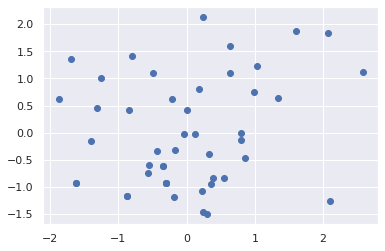

In [ ]:
plt.scatter(Y[:,0], Y[:, 1])

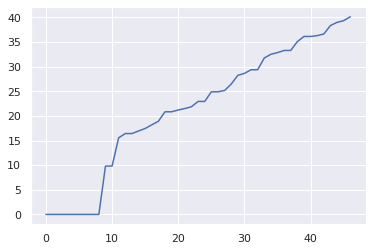

In [ ]:
graficoEps(Y)

In [ ]:
for i in range(20, 36, 1):
    print(f"Per eps={i}")
    db = DBSCAN(eps=i).fit(Y)
    y_pred=db.fit_predict(Y)
    labels = db.labels_
    print(np.unique(labels))
    print(silhouette_score(Y,labels))
    print()

Per eps=20
[-1  0]
-0.009926979

Per eps=21
[-1  0]
-0.0033037707

Per eps=22
[-1  0]
0.0110100545

Per eps=23
[-1  0]
0.0110100545

Per eps=24
[-1  0]
0.017256554

Per eps=25
[-1  0]
0.062296458

Per eps=26
[-1  0]
0.06945355

Per eps=27
[-1  0]
0.10399599

Per eps=28
[-1  0]
0.10999655

Per eps=29
[-1  0]
0.10999655

Per eps=30
[-1  0]
0.11335306

Per eps=31
[-1  0]
0.11335306

Per eps=32
[-1  0]
0.11756425

Per eps=33
[-1  0]
0.12302555

Per eps=34
[-1  0]
0.12419243

Per eps=35
[-1  0]
0.12419243



In [ ]:
db1 = DBSCAN(eps=34).fit(Y)
y_pred1 = db1.fit_predict(Y)
labels1 = db1.labels_
print(np.unique(labels1))
silhouette_score(Y,labels1)

[-1  0]


0.12419243

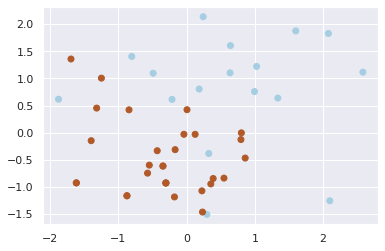

In [ ]:
plt.scatter(Y[:,0], Y[:, 1], c=y_pred1, cmap="Paired")

In [ ]:
# in un dizionario salvo la label del cluster con la lista del id dei tweet le cui immagini appartengono ad esso
group_caps = {}
for i, cluster in enumerate(labels1):
    id = captions[i]['id']
    if cluster not in group_caps.keys():
        group_caps[cluster] =[]
        group_caps[cluster].append(id)
    else:
        group_caps[cluster].append(id)

In [ ]:
group_caps

{-1: ['1596464296720216066',
  '1596464144743628803',
  '1596462433819729920',
  '1596460608957730821',
  '1596455655715446784',
  '1596436921638653952',
  '1596436543576887296',
  '1596428954403061760',
  '1596427779587080195',
  '1596413637820022785',
  '1596411950677651456',
  '1596397340327223297',
  '1596389169550577665',
  '1596388305603813376',
  '1596387740756897792',
  '1596384821571305472',
  '1596377477659602947'],
 0: ['1596453227318460417',
  '1596397715142848512',
  '1596394883979235328',
  '1596393133335404544',
  '1596391184095748096',
  '1596391142933004288',
  '1596391137627242497',
  '1596388620151427073',
  '1596386272414777345',
  '1596385530849427456',
  '1596384532206604291',
  '1596384526271479809',
  '1596384073374904321',
  '1596383952985808902',
  '1596383627092414466',
  '1596383497039613953',
  '1596383195053715457',
  '1596381583665418242',
  '1596380688852619264',
  '1596379406523846656',
  '1596375101502414848',
  '1596373802333585409',
  '15963725084662

In [ ]:
for k in group_caps:   # scorro le labels
    print(f"TWEET APPARTENENTI AL GRUPPO {k}: \n")

    # scorro la lista di id della label k e per ognungo scorro in tweets e ne stampo il testo
    for id in group_caps[k]:
        # avendo l'id del tweets, stampo la sua descrizione da captions
        for c in captions:
            if c['id'] == id:
                print(f"Cap: {c['pred']}")


        for i in range(len(tweets)):
            if tweets[i][0]['id'] == id:
                print(tweets[i][0]['text'])
                print()
    print("\n\n")

TWEET APPARTENENTI AL GRUPPO -1: 

Cap: a painting of a man in a suit and tie


Cap: a painting of a man on a surfboard
tomorrow world cup match japan vs costa rica special illustration by bluelock bluelock project continues more

Cap: a woman in a red dress holding a red and white fire hydrant
vinse due volte loscar per hit come fame e flashdance what feeling la cantante e attrice statunitense irene cara pseudonimo di irene cara escalera si spenta nella sua casa florida ma non stata resa nota la causa del decesso

Cap: a collage of photos showing a woman holding a cell phone
tune day 1 rising stars starting now hosted by casted by

Cap: a night scene with lights on a night stand
time pairs free skate

Cap: a man wearing a suit and tie
pagina dei blazers culto

Cap: a black and white photo of a clock on a wall
lily trailer nier automata ver1 1a anime scheduled january 2023 more

Cap: a woman in a blue dress is standing in front of a wall
new visual spy x family episode 21 more

Cap: a 

# Nuovo modello

In [ ]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image, ImageFile
import requests
import torch

# Definisco il modello utilizzato per le immagini
img_model = SentenceTransformer('clip-ViT-B-32')

# Definisco il modello utilizzato per i testi che mappa piu' di 50 languaggi nello stesso spazio vettoriale
text_model = SentenceTransformer('sentence-transformers/clip-ViT-B-32-multilingual-v1')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/605M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/604 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/115 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/572 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/371 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

In [ ]:
# leggo le immagini
def load_image(url_or_path):
    return Image.open(requests.get(url_or_path, stream=True).raw)

img_paths = []  # lista degli urls delle immagini

for id in urls:
    img_paths.append(urls[id][0])

images = [load_image(img) for img in img_paths]

# genero gli embeddings delle immagini

img_embeddings = img_model.encode(images)
scaler = StandardScaler()
img_embeddings = scaler.fit_transform(img_embeddings)
img_embeddings

# genero gli embeddings solo dei tweets relativi alle immagini
texts = []
for id in urls:
    for i in tweets:
        if tweets[i][0]['id'] == id:
            texts.append(tweets[i][0]['text'])

text_embeddings = text_model.encode(texts)
text_embeddings = scaler.fit_transform(text_embeddings)

In [ ]:
# Compute cosine similarities: indica quanto sono simili i testi dei tweets e le captions generate delle immagini
cos_sim = util.cos_sim(text_embeddings, img_embeddings)

for text, scores in zip(texts, cos_sim):
    max_img_idx = torch.argmax(scores)
    print("Text:", text)
    print("Score:", scores[max_img_idx] )
    print("Path:", img_paths[max_img_idx], "\n")

Text: 
Score: tensor(0.1154)
Path: http://pbs.twimg.com/media/FifHmwjXgAALzIG.jpg 

Text: tomorrow world cup match japan vs costa rica special illustration by bluelock bluelock project continues more
Score: tensor(0.3367)
Path: http://pbs.twimg.com/media/FifHf14X0AA59OF.jpg 

Text: vinse due volte loscar per hit come fame e flashdance what feeling la cantante e attrice statunitense irene cara pseudonimo di irene cara escalera si spenta nella sua casa florida ma non stata resa nota la causa del decesso
Score: tensor(0.1490)
Path: http://pbs.twimg.com/media/FifGHuRWAAIzN4F.jpg 

Text: tune day 1 rising stars starting now hosted by casted by
Score: tensor(0.3188)
Path: http://pbs.twimg.com/media/FifDYODWIAA1Swd.jpg 

Text: time pairs free skate
Score: tensor(0.1715)
Path: http://pbs.twimg.com/media/Fie_9XPWYAI3FKu.jpg 

Text: 44 punti career high proprio al madison vittoria al supplementare e pure questo discreto canestro nel finale jerami grant portland sembra aver trovato definitivament

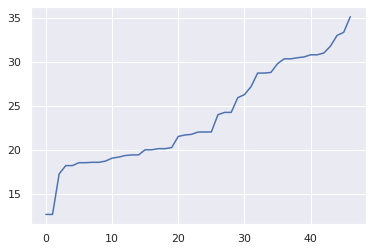

In [ ]:
graficoEps(img_embeddings)

In [ ]:
for i in range(20, 34, 1):
    print(f"Per eps={i}")
    db3 = DBSCAN(eps=i).fit(img_embeddings)
    y_pred=db3.fit_predict(img_embeddings)
    labels3 = db3.labels_
    print(np.unique(labels3))
    print(silhouette_score(img_embeddings,labels3))
    print()

Per eps=20
[-1  0]
0.0319106

Per eps=21
[-1  0  1]
0.017077917

Per eps=22
[-1  0  1]
0.07162924

Per eps=23
[-1  0  1]
0.09054126

Per eps=24
[-1  0]
0.114507005

Per eps=25
[-1  0]
0.12229964

Per eps=26
[-1  0]
0.13163236

Per eps=27
[-1  0]
0.13163236

Per eps=28
[-1  0]
0.13793097

Per eps=29
[-1  0]
0.13793097

Per eps=30
[-1  0  1]
0.14996846

Per eps=31
[-1  0  1]
0.15920606

Per eps=32
[-1  0  1]
0.15896614

Per eps=33
[-1  0]
0.118713096



[-1  0  1]


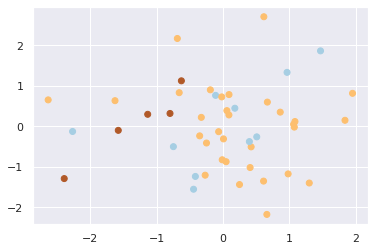

In [ ]:
db3 = DBSCAN(eps=31).fit(img_embeddings)
print(np.unique(db3.labels_))
y_pred3 = db3.fit_predict(img_embeddings)

plt.scatter(img_embeddings[:,0], img_embeddings[:, 1], c=y_pred3, cmap="Paired")

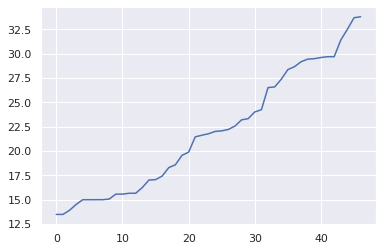

In [ ]:
graficoEps(text_embeddings)

In [ ]:
for i in range(20, 33, 1):
    print(f"Per eps={i}")
    db4 = DBSCAN(eps=i).fit(text_embeddings)
    y_pred=db4.fit_predict(text_embeddings)
    labels4 = db4.labels_
    print(np.unique(labels4))
    print(silhouette_score(text_embeddings,labels4))
    print()

Per eps=20
[-1  0]
-0.006609024

Per eps=21
[-1  0]
-0.006609024

Per eps=22
[-1  0]
0.036303297

Per eps=23
[-1  0]
0.06742975

Per eps=24
[-1  0]
0.08115795

Per eps=25
[-1  0]
0.09389002

Per eps=26
[-1  0]
0.096313424

Per eps=27
[-1  0]
0.10362062

Per eps=28
[-1  0]
0.1109749

Per eps=29
[-1  0]
0.124898724

Per eps=30
[-1  0]
0.16849974

Per eps=31
[-1  0]
0.16849974

Per eps=32
[-1  0]
0.18080875



[-1  0]


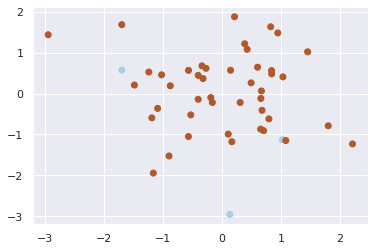

In [ ]:
db4 = DBSCAN(eps=32).fit(text_embeddings)
print(np.unique(db4.labels_))
y_pred4 = db4.fit_predict(text_embeddings)

plt.scatter(text_embeddings[:,0], text_embeddings[:, 1], c=y_pred4, cmap="Paired")

Sommo gli embeddings delle foto e dei testi per ottenere gli embeddings complessivi dei singoli tweet.

In [ ]:
l = len(img_embeddings[0])    # dimensione del singolo embedding
b = len(img_embeddings)       # numero totale di variabili
tweets_emb = np.zeros((b,l))  # matrice contenente la somma degli embeddings
tweets_molt = np.zeros((b,l)) # matrice contenente il prodotto degli embeddings

for i in range(len(img_embeddings)):
    for j in range(len(img_embeddings[0])):
        tweets_emb[i][j] = img_embeddings[i][j] + text_embeddings[i][j]

for i in range(len(img_embeddings)):
    for j in range(len(img_embeddings[0])):
        tweets_molt[i][j] = img_embeddings[i][j] * text_embeddings[i][j]

tweets_emb = scaler.fit_transform(tweets_emb)
tweets_molt = scaler.fit_transform(tweets_molt)

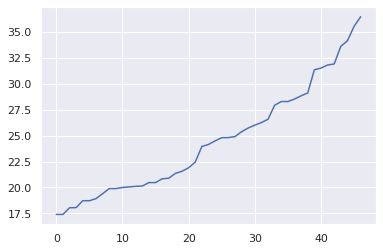

In [ ]:
graficoEps(tweets_emb)

In [ ]:
for i in range(31, 35, 1):
    print(f"Per eps={i}")
    db5 = DBSCAN(eps=i).fit(tweets_emb)
    y_pred=db5.fit_predict(tweets_emb)
    labels5 = db5.labels_
    print(np.unique(labels5))
    print(silhouette_score(tweets_emb,labels5))
    print()

Per eps=31
[-1  0]
0.1471469080149228

Per eps=32
[-1  0]
0.16784530889549823

Per eps=33
[-1  0]
0.17450268558438012

Per eps=34
[-1  0]
0.18012581044040907



[-1  0]


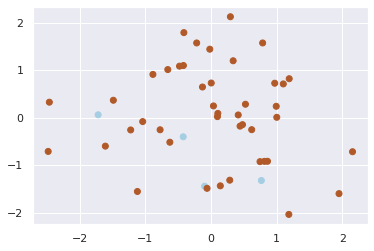

In [ ]:
db5 = DBSCAN(eps=33).fit(tweets_emb)
print(np.unique(db5.labels_))
y_pred5 = db5.fit_predict(tweets_emb)
labels5 = db5.labels_
plt.scatter(tweets_emb[:,0], tweets_emb[:, 1], c=y_pred5, cmap="Paired")

In [ ]:
groups_tweets = {}
for i, cluster in enumerate(labels5):
    id = tweets[i][0]['id']
    if cluster not in groups_tweets.keys():
        groups_tweets[cluster] =[]
        groups_tweets[cluster].append(id)
    else:
        groups_tweets[cluster].append(id)

In [ ]:
for k in groups_tweets.keys():   # scorro tra le labels
    print(f"TWEET APPARTENENTI AL CLUSTER {k}: \n")
    for id in groups[k]:    # scorro tra i tweets che appartengono a un cluster
        for tw in tweets:
            if tweets[tw][0]['id'] == id:
                print(tweets[tw][0]['text'])
    print("\n\n")

TWEET APPARTENENTI AL CLUSTER -1: 

iran s supreme leader has praised country s basij paramilitary force its role deadly crackdown anti regime protesters

tomorrow world cup match japan vs costa rica special illustration by bluelock bluelock project continues more
we are now live with rising stars womens league legends tournament joining us stream today
spacex will once again try get fresh haul supplies international space station this weekend after bad weather at launch site forced company wave off its first attempt
tune day 1 rising stars starting now hosted by casted by
this early cyber monday deal nets you lenovo tab p11 plus detachable keyboard lenovo precision pen 2 under 300
masterchef australia 14 accoglie liconico chef marco pierre white
time pairs free skate
one ukraine s largest state hospitals was verge evacuating some patients after it lost water supply because russian air strikes wednesday regional official told cnn
with all black friday cyber monday deals flowing now is 

[-1  0]


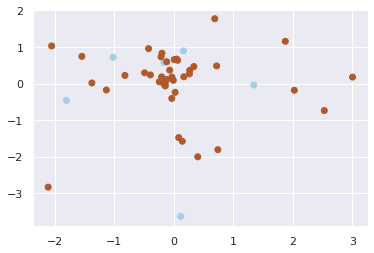

In [ ]:
db6 = DBSCAN(eps=33).fit(tweets_molt)
print(np.unique(db6.labels_))
y_pred6 = db6.fit_predict(tweets_molt)
labels6 = db6.labels_
plt.scatter(tweets_molt[:,0], tweets_molt[:, 1], c=y_pred6, cmap="Paired")

In [ ]:
groups_tweets = {}
for i, cluster in enumerate(labels5):
    id = tweets[i][0]['id']
    if cluster not in groups_tweets.keys():
        groups_tweets[cluster] =[]
        groups_tweets[cluster].append(id)
    else:
        groups_tweets[cluster].append(id)

In [ ]:
for k in groups_tweets.keys():   # scorro tra le labels
    print(f"TWEET APPARTENENTI AL CLUSTER {k}: \n")
    for id in groups[k]:    # scorro tra i tweets che appartengono a un cluster
        for tw in tweets:
            if tweets[tw][0]['id'] == id:
                print(tweets[tw][0]['text'])
    print("\n\n")

TWEET APPARTENENTI AL CLUSTER 0: 

si pu rivoluzionare un classico rimanendovi fedele profondit certamente purch compierlo sia la mente di un grande artista
frana ischia sono almeno 8 i morti accertati
incidenti stradali nola tre giovani si schiantano un morto
previsioni meteo arrivo una serie di cicloni il primo quello che sta colpendo ischia
vittorio cecchi gori ho comprato una casa di trump e oggi mi ritrovo spolpato da gente senza scrupoli
fino al 27 novembre al teatro carcano va scena le nostre anime di notte
clima frana ischia sima 130 eventi estremi solo nel 2022 1 318 dal 2010
sondaggi politici meloni fiducia governo
esplosione bombole gas nel reggino un morto e due feriti
l incontro era nell aria dopo le ripetute critiche delle madri russe alla guerra cui vengono mandati morire i propri figli
vinse due volte loscar per hit come fame e flashdance what feeling la cantante e attrice statunitense irene cara pseudonimo di irene cara escalera si spenta nella sua casa florida ma non 